In [1]:
"""Temporary fix for importing modules from parent directory"""

import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from varitop.misc import euler_rule, skew_quaternion, qconj, q2rm, quat_prod
from varitop.integrator import DelIntegrator as DI

In [3]:
from darli.model import Functional
from darli.backend import CasadiBackend

In [17]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import casadi as cs
import numpy as np
import pinocchio as pin

In [5]:
urdf_path = "../assets/urdf/skydio_x2.urdf"
darli_model = Functional(CasadiBackend(urdf_path=urdf_path))

In [6]:
linear_0 = np.array([0, 0, 0])
angular_0 = np.array([0, 0, 0, 1])
q_0 = np.concatenate((linear_0, angular_0))

In [7]:
selector = np.array([[0.0, 0.0, 0.0, 0.0],
                     [0.0, 0.0, 0.0, 0.0],
                     [1.0, 1.0, 1.0, 1.0],
                     [-0.18, 0.18, 0.18, -0.18],
                     [0.14, 0.14, -0.14, -0.14],
                     [-0.0201, 0.0201, 0.0201, -0.0201]])

t0, tf, steps = 0.0, 3.0, 200
dt = (tf - t0) / steps

In [8]:
di = DI(
    nq = darli_model.nq,
    nu = 4,
    free_body=True,
    selector=selector,
    lagrangian=darli_model.lagrangian,
)

In [9]:
di.q[3:].T @ di.q[3:] - 1

SX(((((sq(q_3)+sq(q_4))+sq(q_5))+sq(q_6))-1))

In [10]:
di.add_constraint(di.q[3:].T @ di.q[3:] - 1)

In [11]:
di._dynamics_constraint

Function(phi:(q[7])->(phi) SXFunction)

In [12]:
# Constant input
us = np.full((steps, 4), np.array([0.00, 0.00, 0.0005, 0.0005]))

In [13]:
di.get_residual()

Function(del:(q-1[7],q[7],q+1[7],dt,lambda,u[4])->(DEL Residual[8]) SXFunction)

In [14]:
di.get_rf_residual()

Function(rf:(i0[8],i1[7],i2[7],i3,i4[4])->(o0[8]) Newton)

In [15]:
qs_sol = np.zeros((steps, 7))
qs_sol[0] = q_0
qs_sol[1] = q_0

for i in tqdm(range(2, steps)):
    q0 = qs_sol[i - 2]
    q1 = qs_sol[i - 1]

    qs_sol[i] = di.step(q0, q1, dt, us[i])

  0%|          | 0/198 [00:00<?, ?it/s]

100%|██████████| 198/198 [00:02<00:00, 90.58it/s]


In [16]:
print(qs_sol.shape)

(200, 7)


In [29]:
basis_vectors = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
rms = np.array([pin.XYZQUATToSE3(qi).rotation for qi in qs_sol])

In [30]:
# Quaternion angular velocity
def w(q, dq):
    return 2 * quat_prod(qconj(q), dq)

In [31]:
ws_sol = np.zeros((steps, 4))
ws_sol[0] = np.zeros(4)
for i in range(1, len(ws_sol)):
    dqs_i = (qs_sol[i] - qs_sol[i - 1]) / dt
    ws_sol[i] = np.array(w(qs_sol[i, 3:], dqs_i[3:])).ravel()

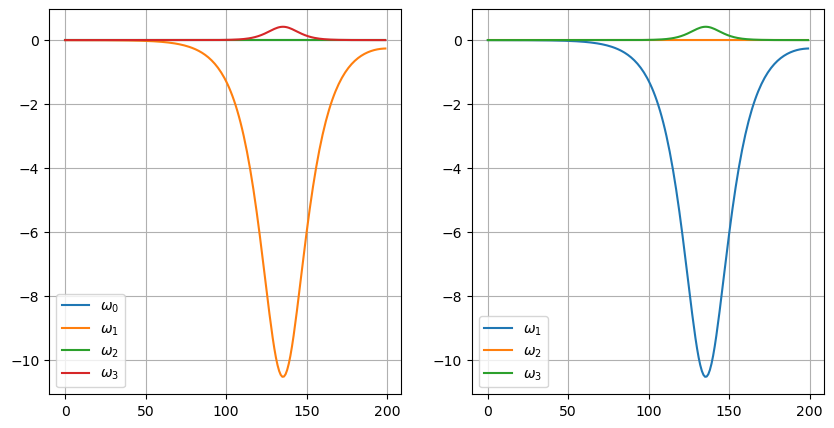

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(ws_sol[:, 0], label="$\omega_0$")
ax[0].plot(ws_sol[:, 1], label="$\omega_1$")
ax[0].plot(ws_sol[:, 2], label="$\omega_2$")
ax[0].plot(ws_sol[:, 3], label="$\omega_3$")

ax[1].plot(ws_sol[:, 1], label="$\omega_1$")
ax[1].plot(ws_sol[:, 2], label="$\omega_2$")
ax[1].plot(ws_sol[:, 3], label="$\omega_3$")

ax[0].grid()
ax[0].legend()
ax[1].grid()
ax[1].legend()
plt.show()

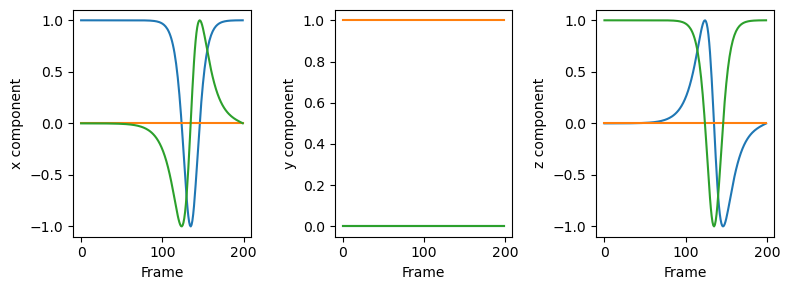

In [33]:
import matplotlib.pyplot as plt

# Extract the x, y, z components of the basis vectors
x = rms[:, 0]
y = rms[:, 1]
z = rms[:, 2]

# Create three separate plots for x, y, z components
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3))

# Plot x component
ax1.plot(x)
ax1.set_xlabel("Frame")
ax1.set_ylabel("x component")

# Plot y component
ax2.plot(y)
ax2.set_xlabel("Frame")
ax2.set_ylabel("y component")

# Plot z component
ax3.plot(z)
ax3.set_xlabel("Frame")
ax3.set_ylabel("z component")

# Display the plots
plt.tight_layout()
plt.show()

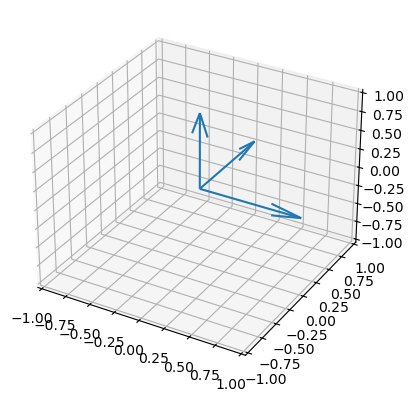

In [34]:
from matplotlib.animation import FuncAnimation

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

basis = ax.quiver(0, 0, 0, basis_vectors[0], basis_vectors[1], basis_vectors[2])


def update(frame):
    # Rotate the basis vectors
    rotated_vectors = rms[frame] @ basis_vectors.T

    global basis
    basis.remove()
    basis = ax.quiver(
        0, 0, 0, rotated_vectors[0], rotated_vectors[1], rotated_vectors[2]
    )


# Create the animation
animation = FuncAnimation(fig, update, frames=len(qs_sol), interval=tf * 1000 / steps)

# Save the animation as a GIF using Pillow writer
animation.save("evolution_history_x2.gif")

# Display the animation
plt.show()